In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import product
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from math import ceil


In [2]:
dataset = pd.read_csv('dataset.csv')
dataset.drop(columns='Unnamed: 0', inplace=True, axis=1)
dataset.local_date = pd.to_datetime(dataset.local_date)
dataset.local_date = dataset.local_date.round('H')
dataset['hour'] = dataset.local_date.dt.hour
# dataset['month'] = dataset.local_date.dt.month
# dataset['year'] = dataset.local_date.dt.year
dataset['day'] = dataset.local_date.dt.day
dataset['revenue'] = dataset.price*dataset.quantity
dataset = dataset[dataset.local_date.dt.year >= 2021]
dataset = dataset[dataset.local_date.dt.month >= 2]
dataset = dataset[dataset.local_date.dt.day >= 1]
dataset = dataset[dataset.quantity > 0]
dataset = dataset[dataset.price > 0]
dataset['region'] = dataset['region'].astype('category')
dataset['region_str'] = dataset['region'].astype('category')
dataset['region'] = dataset['region'].cat.codes


dataset.dropna(inplace=True)


In [3]:
dataset.describe()

,item_id,receipt_id,device_id,price,quantity,region,hour,day,revenue
count,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06
mean,1.169169e+10,7.382236e+09,3.524287e+14,1.444292e+02,1.851711e+00,4.073841e+01,1.462635e+01,3.580773e+00,1.605691e+02
std,2.543894e+07,1.441252e+07,3.246692e+11,1.142864e+03,1.501325e+01,2.319679e+01,3.787953e+00,1.700235e+00,1.366103e+03
min,1.164705e+10,7.356678e+09,3.523991e+14,1.000000e-02,1.000000e-03,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-02
25%,1.166987e+10,7.369880e+09,3.524015e+14,3.100000e+01,1.000000e+00,2.200000e+01,1.200000e+01,2.000000e+00,3.800000e+01
50%,1.169178e+10,7.382427e+09,3.524038e+14,7.000000e+01,1.000000e+00,3.700000e+01,1.500000e+01,4.000000e+00,8.400000e+01
75%,1.171401e+10,7.394917e+09,3.524060e+14,1.350000e+02,1.000000e+00,6.200000e+01,1.800000e+01,5.000000e+00,1.430000e+02
max,1.173505e+10,7.406571e+09,3.566551e+14,1.000000e+06,4.280000e+03,8.400000e+01,2.300000e+01,7.000000e+00,1.000000e+06


In [4]:
for col in dataset.columns:    
    unique = dataset[col].unique()
    print('Feature: {0} unique: {1}\n'.format(col, len(unique)))
    print(unique,'\n')

Feature: item_id unique: 1015306

[11660931229 11660931230 11660931773 ... 11660931118 11660931119
 11660931120] 

Feature: receipt_id unique: 508250

[7364786357 7364786673 7364786762 ... 7364786210 7364786218 7364786270] 

Feature: device_id unique: 3186

[352402250963288 352403179996511 352403718712896 ... 352405120366626
 352402001420454 352405211401395] 

Feature: local_date unique: 152

['2021-02-02T00:00:00.000000000' '2021-02-02T02:00:00.000000000'
 '2021-02-02T01:00:00.000000000' '2021-02-02T03:00:00.000000000'
 '2021-02-02T05:00:00.000000000' '2021-02-02T07:00:00.000000000'
 '2021-02-01T00:00:00.000000000' '2021-02-01T07:00:00.000000000'
 '2021-02-01T02:00:00.000000000' '2021-02-01T06:00:00.000000000'
 '2021-02-01T03:00:00.000000000' '2021-02-01T01:00:00.000000000'
 '2021-02-01T08:00:00.000000000' '2021-02-06T17:00:00.000000000'
 '2021-02-06T10:00:00.000000000' '2021-02-06T11:00:00.000000000'
 '2021-02-06T14:00:00.000000000' '2021-02-06T15:00:00.000000000'
 '2021-02-06T16:00:

In [5]:
# br=dataset.barcode.value_counts()
# import requests
# from urllib.request import Request, urlopen
# import urllib
# from bs4 import BeautifulSoup

# headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5) AppleWebKit 537.36 (KHTML, like Gecko) Chrome","Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"}

# def google(q):
#     q = '+'.join(q.split())
#     url = 'https://www.google.com/search?q=' + q + '&ie=utf-8&oe=utf-8'
#     reqest = Request(url,headers=headers)
#     page = urlopen(reqest)
#     soup = BeautifulSoup(page)
#     return soup.text

# for key, value in br[:500].to_dict().items():
#     req = google(key)
#     req = req.split('выполнена в течение нескольких секунд.')[1][:62]
#     if 'Cola' in req:
#         print(key, req, value)

In [6]:
# 5449000228970        Напиток газированный Coca-Cola 0,9 л, код 5449000228970 719
# 5449000000286        Напиток безалкогольный сильногазированный Coca-Cola п/б 712
# 5449000000996        Вода Coca-Cola ж/б 0.33л Coca-Cola 5449000000996: купит 525
# 54491472        Напиток безалкогольный сильногазированный Coca-Cola п/б 485
# 4600494602481        Напиток Pepsi-Cola б/алк газ 2л пэт, размер 10.35/10.35 465
# 4600494602269        Напиток Pepsi-Cola б/алк газ 1л пэт, размер 8.20/8.20/2 403

In [7]:
df = dataset[dataset.barcode.isin(['4600494602269', 
                                   '4600494602481' ,
                                   '5449000000996',
                                   '5449000228970', 
                                   '5449000000286', 
                                   '54491472'
            ])].copy()

# df = dataset[dataset.barcode.isin(['2000000000008', 
                                   
#             ])].copy()
df['local_date'] = pd.to_datetime(df['local_date'])
df.reset_index(drop=True, inplace=True)

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'quantity'}>]], dtype=object)

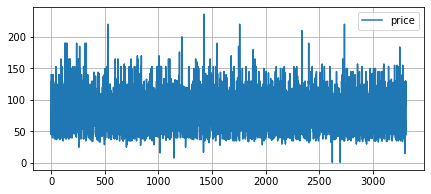

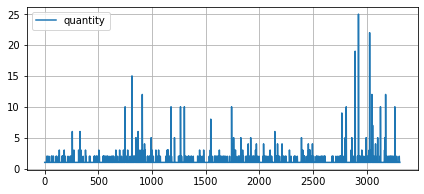

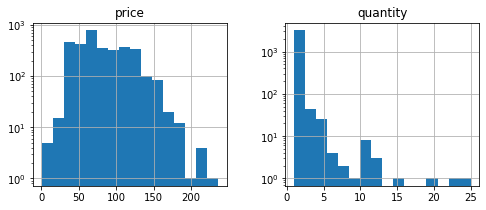

In [8]:
df.plot(y='price', kind='line', figsize=(7,3), grid=True, use_index=True)
df.plot(y='quantity', kind='line', figsize=(7,3), grid=True, use_index=True)
df.hist(column=['price', 'quantity'],bins=16, log=True, figsize=(8,3))

In [9]:
def fe(cols_gb, fe_df, matrix, feats, stats, prefix):    
    # agg features
    group = fe_df.groupby(cols_gb)[feats].agg(stats).reset_index()
    if 'local_date' in cols_gb:
        group.local_date = pd.to_datetime(group.local_date)
        matrix.local_date = pd.to_datetime(matrix.local_date)
    # merge
    matrix = matrix.merge(
        group
        , how='left'
        , on=cols_gb
    )
    matrix.fillna(0, inplace=True)    
    matrix.columns = [prefix+"_".join(col).strip() if len(col) == 2 else col for col in matrix.columns.values]    
#     print(matrix.columns.values)
    return matrix

def lag_feature(df, lags, col):
    tmp = df[['region', 'local_date',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['region', 'local_date', col+'_lag_'+str(i)]
        shifted['local_date'] += pd.Timedelta(hours=i)
        df = pd.merge(df, shifted, on=['region', 'local_date'], how='left')
    return df

In [10]:
def make_feature(dataset, regions, day, mode):
    
    matrix = []
    cols = ['region','local_date']
     
    dates = np.array(pd.date_range(dataset.local_date.min(), dataset.local_date.max() + pd.Timedelta(days=1), freq="1h").to_pydatetime()).astype('datetime64[ns]')
    matrix = list(product(regions, dates))    
    matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
    matrix.local_date = pd.to_datetime(matrix.local_date)
    matrix['year'] = matrix.local_date.dt.year
    matrix['month'] = matrix.local_date.dt.month
    matrix['day'] = matrix.local_date.dt.day
    matrix['hour'] = matrix.local_date.dt.hour

    cols_gb = ['region', 'local_date']
    feats = ['quantity']
    stats = ['sum']
    prefix=''
    matrix = fe(cols_gb, dataset, matrix, feats, stats, prefix)
    
#     masked_train = (matrix.day < day) 
#     masked_valid = (matrix.day == day) 
#     masked_test = (matrix.day > day)
    
    masked_train = matrix.local_date < day
    masked_valid = matrix.local_date.between(day, day+pd.Timedelta(days=1, hours=1), inclusive=True)
    masked_test = matrix.local_date > day + pd.Timedelta(days=1)
     
    matrix.loc[(masked_train), 'train_or_test'] = 'train'
    matrix.loc[(masked_valid), 'train_or_test'] = 'val'
    matrix.loc[(masked_test), 'train_or_test'] = 'test'
        
#     print('Train shape: {}'.format(matrix.loc[matrix.train_or_test=='train',:].shape))
#     print('Validation shape: {}'.format(matrix.loc[matrix.train_or_test=='val',:].shape))  
#     print('No train shape: {}'.format(matrix.loc[matrix.train_or_test=='test',:].shape))  
        
    train = matrix.loc[matrix.train_or_test.isin(['train','val']), :].copy()
    Y_train = train.loc[train.train_or_test=='train', 'quantity_sum'].reset_index(drop=True)
    Y_valid = train.loc[train.train_or_test=='val', 'quantity_sum'].reset_index(drop=True)
    train.loc[train.train_or_test=='val', ['quantity_sum']] = np.nan
    train.loc[train.train_or_test=='test', ['quantity_sum']] = np.nan
    
    lags = [24,36,48]
    train = lag_feature(train, lags, 'quantity_sum')
    cols_to_drop = []
    
#     #Добавляем "скользящие" признаки
#     train = create_sales_rmean_feats(train, cols_gb=['region'], 
#                                  feats='quantity_sum', windows=[4,12,24], 
#                                  min_periods=4, win_type='triang')

#     train = create_sales_rmed_feats(train, cols_gb=['region'], 
#                                 feats='quantity_sum', windows=[4,12,24], 
#                                 min_periods=4, win_type=None)

#     train = create_sales_ewm_feats(train, cols_gb=['region'], 
#                                feats='quantity_sum', 
#                                alpha=[0.95, 0.9, 0.85], 
#                                shift=[1,4,8])
    
    cols_to_drop += ['year', 'month','train_or_test','quantity_sum']
    features = [col for col in train.columns.values if col not in cols_to_drop]

    categorical_feats = ['region',
                     'day',
                     'hour']
    for col in categorical_feats:
        train[col] = train[col].astype('category')
        
    X_train = train.loc[train.train_or_test=='train', features].reset_index(drop=True)
    X_valid = train.loc[train.train_or_test=='val', features].reset_index(drop=True)
    
    return X_train, Y_train, X_valid, Y_valid, matrix
    
    


In [11]:
mode = 'train'
valid_day = df.local_date.max()-pd.Timedelta(days=1)
regions = dataset.region.unique()

#Разбиваем на обучающую/валидационную выборки
X_train,Y_train, X_valid, Y_valid, matrix = make_feature(df, regions, valid_day, mode)
train_df = pd.concat([X_train, Y_train], axis=1)
valid_df = pd.concat([X_valid, Y_valid], axis=1)

C:\Users\bognev\anaconda3\envs\tf-gpu-clone\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\bognev\anaconda3\envs\tf-gpu-clone\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [13]:
from sklearn.metrics import mean_absolute_error

def plot_forecast(series_train, series_test, forecast):

    mae = mean_absolute_error(series_test, forecast)
#     mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 2))
    plt.title(f"MAE: {mae:.2f}", size=18)#, MAPE: {mape:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")    
    plt.legend(prop={"size": 16})
    plt.show()

    return mae#, mape

def plot_grid_forecast(i, ax, series_train, series_test, forecast):  
    ax[i].plot(series_train, label="train", color="b")
    ax[i].plot(series_test, label="test", color="g")
    forecast.index = series_test.index
    ax[i].plot(forecast, label="forecast", color="r")
    ax[i].legend(prop={"size": 16})

def make_series(train_df, valid_df, date_before, time_index=True):
    t_train, t_valid = [], []
    regions = train_df.region.unique()
    for reg in regions:        
#         X.reset_index(drop=True, inplace=True)
        train = train_df[train_df.region == reg][['local_date', 'quantity_sum']].copy()
        valid = valid_df[valid_df.region == reg][['local_date', 'quantity_sum']].copy()
        if time_index:
            train=train.set_index(pd.DatetimeIndex(train.local_date, freq='1h'))
            valid=valid.set_index(pd.DatetimeIndex(valid.local_date, freq='1h'))        
                  
        t_train.append(train)
        t_valid.append(valid)
    return t_train, t_valid  

In [14]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last", sp=24)

PLT=True
naive_mae, naive_r2 = [], []
train, valid = make_series(train_df, valid_df, valid_day, time_index=True)
periods = len(valid[0])
fh = ForecastingHorizon(
        pd.DatetimeIndex(pd.date_range(valid_day, periods=periods, freq="1h")), is_relative=False
)
if PLT:
    fig, ax = plt.subplots(ceil(len(regions)/3), 3, figsize=(20, 60))
    ax = ax.flatten()
for i, reg in enumerate(regions):  
    
        
    series_train = train[i].quantity_sum
    series_valid = valid[i].quantity_sum    
    forecaster.fit(series_train)
    forecast = forecaster.predict(fh)
    # plotting predictions and past data
    mae = mean_absolute_error(series_valid, forecast)
    r2 = r2_score(series_valid, forecast)
    naive_mae.append(mae)
    naive_r2.append(r2)
    if PLT:
        plot_grid_forecast(i, ax, series_train, series_valid, forecast)
#     (y.quantity_sum, y_pred, labels=["y", "y_pred"])
naive_mae = np.array(naive_mae)
print(naive_mae.mean())
naive_r2 = np.array(naive_r2)
print(naive_r2.mean())
if PLT:
    plt.tight_layout() 


NameError: name 'ForecastingHorizon' is not defined

In [ ]:
sum(valid_df.region==33)

In [ ]:
from sktime.forecasting.ets import AutoETS
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)


forecaster = AutoETS(auto=True, n_jobs=1, sp=24)

PLT=True
ets_mae, ets_r2 = [], []
train, valid = make_series(train_df, valid_df, valid_day, time_index=True)
periods = len(valid[0])
fh = ForecastingHorizon(
        pd.DatetimeIndex(pd.date_range(valid_day, periods=periods, freq="1h")), is_relative=False
)

if PLT:
    fig, ax = plt.subplots(ceil(len(regions)/3), 3, figsize=(20, 60))
    ax = ax.flatten()
with np.errstate(divide='ignore'):
    for i, reg in enumerate(regions):
        series_train = train[i].quantity_sum
        series_valid = valid[i].quantity_sum
    #         fh = np.arange(1, len(series_valid) + 1)
        forecaster.fit(series_train + 1)
        forecast = forecaster.predict(fh)
        # plotting predictions and past data
        forecast = forecast - 1
        mae = mean_absolute_error(series_valid, forecast)
        r2 = r2_score(series_valid, forecast)
        ets_mae.append(mae)
        ets_r2.append(r2)
        if PLT:
            plot_grid_forecast(i, ax, series_train, series_valid, forecast)
ets_mae = np.array(ets_mae)
print(ets_mae.mean())
ets_r2 = np.array(ets_r2)
print(ets_r2.mean())
print(ets_mae)
print(ets_r2)
if PLT:
    plt.tight_layout() 


In [ ]:
from sktime.forecasting.ets import AutoETS
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)




forecaster = AutoETS(auto=True, n_jobs=1, sp=24)
date_before = pd.to_datetime(datetime(2021, 2, 6, 0, 0))
PLT=True
ets_mae, ets_r2 = [], []

mode = 'test'
test_day = df.local_date.max() + pd.Timedelta(hours=1)
X_train,Y_train, X_test, Y_test, matrix = make_feature(df, regions, test_day, mode)
train_df = pd.concat([X_train, Y_train], axis=1)
test_df = pd.concat([X_test, Y_test], axis=1)
train, test = make_series(train_df, test_df, test_day, time_index=True)

periods = len(test[0])
fh = ForecastingHorizon(
        pd.DatetimeIndex(pd.date_range(test_day, periods=periods, freq="1h")), is_relative=False
)

if PLT:
    fig, ax = plt.subplots(ceil(len(regions)/3), 3, figsize=(20, 60))
    ax = ax.flatten()
with np.errstate(divide='ignore'):
    for i, reg in enumerate(regions):
        series_train = train[i].quantity_sum
        series_test = test[i].quantity_sum
    #         fh = np.arange(1, len(series_test) + 1)
        forecaster.fit(series_train + 1)
        forecast = forecaster.predict(fh)
        # plotting predictions and past data
        forecast = forecast - 1
        mae = mean_absolute_error(series_test, forecast)
        r2 = r2_score(series_test, forecast)
        ets_mae.append(mae)
        ets_r2.append(r2)
        if PLT:
            plot_grid_forecast(i, ax, series_train, series_test, forecast)
ets_mae = np.array(ets_mae)
print(ets_mae.mean())
ets_r2 = np.array(ets_r2)
print(ets_r2.mean())
print(ets_mae)
print(ets_r2)
if PLT:
    plt.tight_layout() 


In [ ]:
print('Naive mean mae ', naive_mae.mean())
print('LGB mean mae ', lgb_mae.mean())
print('MO mean mae ', mo_mae.mean())

print('Naive R2 ', naive_r2.mean())
print('LGB R2 ', lgb_r2.mean())
print('MO R2 ', mo_r2.mean())

for lgb,naive,mo in zip(lgb_mae, naive_mae, mo_mae):
    print(f'{lgb:.2f} {naive:.2f} {mo:.2f}')
    
fig, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.plot(lgb_mae, color="b", label='lgb')
ax.plot(naive_mae, color="g", label='naive')
ax.plot(mo_mae, color="r", label='MO')
ax.set_title('MAE for regions')
ax.legend(prop={"size": 10})
   

